# 3. MAGIC Light Curve estimation

In this notebook, we will illustrate how to extract a light curve using the `Datasets` we produced.

In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
import glob
import uproot
import matplotlib.pyplot as plt

from gammapy.modeling.models import Models, create_crab_spectral_model
from gammapy.datasets import SpectrumDatasetOnOff, Datasets
from gammapy.estimators import LightCurveEstimator

Both for SED and for light curve, `flute` estimates flux points by counting the number of excess events in a given estimated energy bin (or above a certain energy) and dividing them by the effective area multiplied by the effective time.

For SED:
$$\frac{{\rm d}\phi}{{\rm d}E}(E_{\rm est, i} < E < E_{\rm est, i+1}) [{\rm TeV}^{-1}\,{\rm cm}^{-2}\,{\rm s}^{-1}]
= \frac{
    N_{\rm ex}(E_{\rm est, i} < E < E_{\rm est, i+1})
   }{
    A_{\rm eff}(E_{\rm est, i} < E < E_{\rm est, i+1}) \, t_{\rm eff} \, \Delta E_{\rm est}} $$

For LC:
$$\phi(E > E_{\rm est}) = \frac{N_{\rm ex}(E > E_{\rm est})}{A_{\rm eff}(E > E_{\rm est}) \, t_{\rm eff}} $$

To obtain SED flux points in true energies we have to use the unfolding.

These are approximated formulae, more details in [Abelardo's slides on flux estimation, software school.](https://indico.mpp.mpg.de/event/7771/contributions/25100/attachments/16353/19350/Abelardo_FluxTheory_SWschool2021.pdf)

`Gammapy` estimates SED and LC flux points by repeating the forward folding likelihood we saw in the previous tutorial. In the case of an SED flux points all the events in a single energy bin are considered. In case of a LC flux points all the events in a given time bin and above a certain energy are used. Hence, we need a model to estimate the flux points in Gammapy, I use the result of the broad-band likelihood fit. And re-fit only the normalisation.

As for many other objects, also models are serialisable in `Gammapy`, that is they can be written and read from memory. We read the log parabola best-fit model we otbained on the stacked dataset.

In [2]:
models = Models.read("results/gammapy/fit/magic/dataset_stacked_best_fit.yml")
print(models)

Models

Component 0: SkyModel

  Name                      : CrabNebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.02e-11   +/- 1.5e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.582   +/-    0.07             
    beta                          :      0.120   +/-    0.04             




In [3]:
# read the datasets
datasets = Datasets()

ogip_files = glob.glob(
    "results/gammapy/spectra/magic/pha_obs_5*.fits"
)  # put 5 not to read the stacked one

for ogip_file in ogip_files:
    if (
        ("arf" not in ogip_file)
        and ("rmf" not in ogip_file)
        and ("bkg" not in ogip_file)
    ):
        datasets.append(SpectrumDatasetOnOff.read(ogip_file))

In [4]:
# copy the best fit model and freeze all the spectral parameters but the
# amplitude before computing flux points
flux_estimator_model = models["CrabNebula"].copy()
flux_estimator_model.spectral_model.parameters["alpha"].frozen = True
flux_estimator_model.spectral_model.parameters["beta"].frozen = True
flux_estimator_model._name = "CrabNebula"
# assign it to the datasets
datasets.models = [flux_estimator_model]

In [5]:
energy_edges = [300 * u.GeV, 100 * u.TeV]

time_intervals = [
    [Time(58109.94, format="mjd"), Time(58110.00, format="mjd")],
    [Time(58140.94, format="mjd"), Time(58140.98, format="mjd")],
]

light_curve_estimator = LightCurveEstimator(
    energy_edges=energy_edges,
    time_intervals=time_intervals,
    source="CrabNebula",
    reoptimize=False,
    n_sigma_ul=3,
)

light_curve = light_curve_estimator.run(datasets)

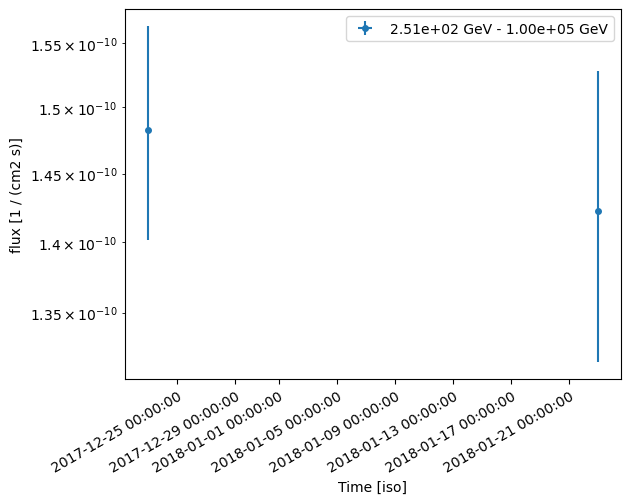

In [6]:
light_curve.plot(sed_type="flux")
plt.show()

### Comparison with MARS
Compare with the same light curve obtained with `flute`.

In [7]:
flute_file = uproot.open("../SWschool2023/data/S3.1/flute/Output_flute.root")

light_curve_mars = flute_file["LightCurve"].tojson()

# flux points
mjd_mars = np.asarray(light_curve_mars["fX"])
mjd_err_mars = np.asarray(light_curve_mars["fEX"])
flux_mars = np.asarray(light_curve_mars["fY"])
flux_err_mars = np.asarray(light_curve_mars["fEY"])

In [8]:
# Gammapy LC
time_axis = light_curve.geom.axes["time"]
mjd_gammapy = time_axis.time_mid
mjd_err_gammapy = (time_axis.time_mid - time_axis.time_min).value
flux_gammapy = light_curve.flux.to_unit("cm-2 s-1").data.flatten()
flux_err_gammapy = light_curve.flux_err.to_unit("cm-2 s-1").data.flatten()

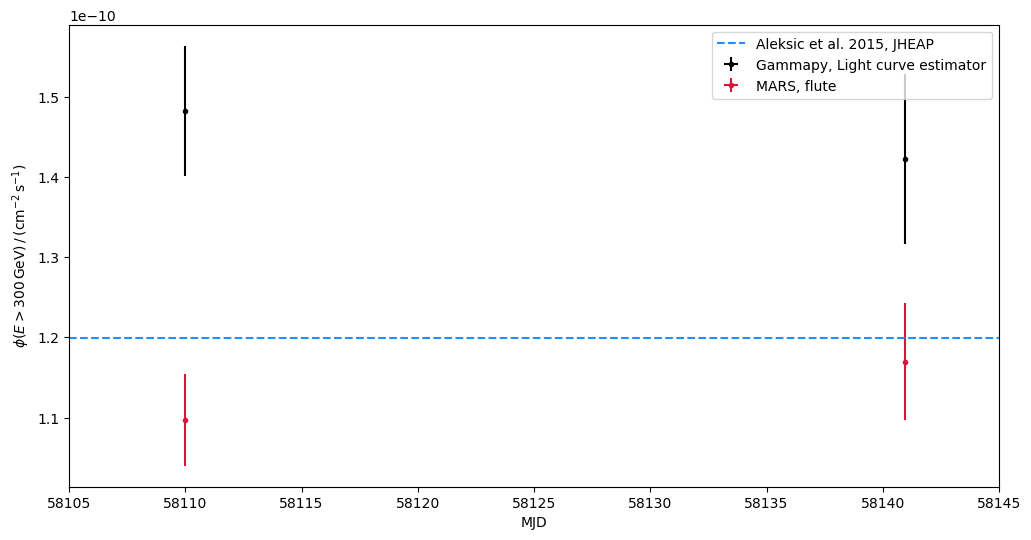

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.errorbar(
    mjd_gammapy.value,
    flux_gammapy,
    xerr=mjd_err_gammapy,
    yerr=flux_err_gammapy,
    ls="",
    marker=".",
    color="k",
    label="Gammapy, Light curve estimator",
)

ax.errorbar(
    mjd_mars,
    flux_mars,
    xerr=mjd_err_mars,
    yerr=flux_err_mars,
    ls="",
    marker=".",
    color="crimson",
    label="MARS, flute",
)

# plot reference Crab integrated flux
crab_magic_lp = create_crab_spectral_model("magic_lp")
phi_crab_ref = crab_magic_lp.integral(energy_edges[0], energy_edges[1])
ax.axhline(phi_crab_ref.to_value("cm-2 s-1"), ls="--", color="dodgerblue", label="Aleksic et al. 2015, JHEAP")

ax.legend()

# make ticks human readable
ticks = ax.get_xticks()
labels = [f"{int(_):d}" for _ in ticks]
ax.set_xticks(ticks, labels)

ax.set_ylabel(r"$\phi(E > 300\,{\rm GeV})\,/\,({\rm cm}^{-2}\,{\rm s}^{-1})$")
ax.set_xlabel("MJD")
plt.show()